# Inference in a neural emulation model



Look, we can do approximate probabilistic inference with a complicated neural network! Here we will use a 2-million parameter neural net to generate a an approximate likelihood for inference in a model.



## Set up

In [1]:
import numpy as np
from math import sqrt, ceil, floor

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.functional import F 

from src.graphs import fno_graph
from src.plots import img_plot, multi_img_plot_batch, multi_img_plot_time, multi_heatmap


# device = torch.device('cuda')  # I can't make MCMC work on the GPU 😢
device = torch.device('cpu')


## The data

We have a dataset of snapshots from a [Navier-Stokes](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations) simulator.

This dataset is packed as as $(b, x, y, t)$ i.e. batch first, coordinates in the middle, time last. 

In [2]:
data = np.load('./data/grf_forcing_single.npz')

def get_obs(data, t=0, n_steps=2, y=False):
    """
    helper function to parse the data into cunks with teh correct size and names for the model
    """
    x = data['u'][..., t:t+n_steps]
    latent = data['f'][...]
    obs= {
        'x': x,
        'latent': latent
    }
    if y:
        obs['y'] = data['u'][..., t+n_steps]

    return obs

def dict_as_tensor(d, device=device):
    """
    Send a dict of arrays to pytorch tensors.
    it was faster to write this function than to search the docs for it
    """
    return {k: torch.as_tensor(v).to(device) for k, v in d.items()}

## Visualise the data

First we look at the snapshots of the simulation. First the vorticity field $x(t)$:

range(0, 19, 5) 4 4


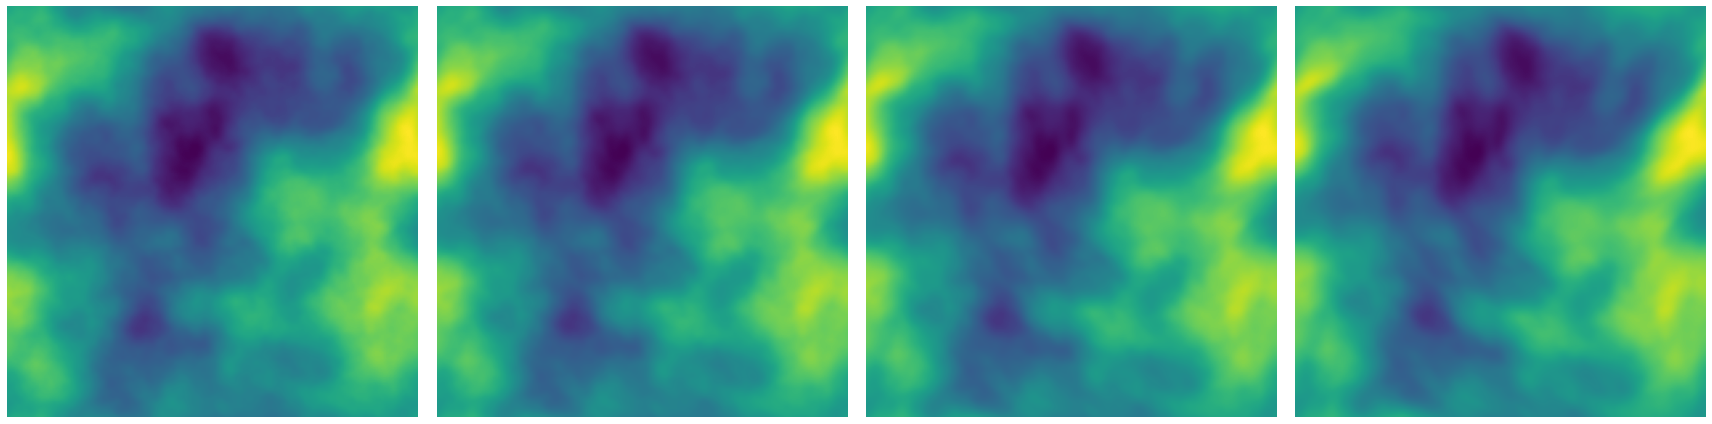

In [3]:
multi_img_plot_time(get_obs(data, 0, -1)['x'], n_cols=4, interval=5);

Next we look at the _latent forcing_, which is a time-invariant field that perturbs the dynamics of $x$

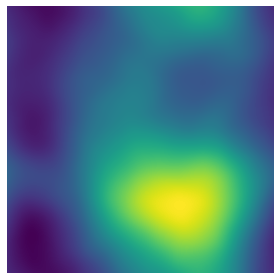

In [4]:
img_plot(get_obs(data, 0, -1)['latent']);

## Process predictor model

Running a PDE simulator is expensive, so have trained a neural network which can hopefully reproduce these observations, by giving it a data set of 1000 simulations made up of many snapshots. The details of the network are on [Zongyi Li’s blog](https://zongyi-li.github.io/blog/2020/fourier-pde/).

NB the data we have here is from the validation set — the neural network has not seen this data during the training phase.

In [5]:
from src.nn_modules.fourier_2d_generic import SimpleBlock2dGeneric

pp_state_dict = torch.load(
    './models/fno_forward.ckpt',
    map_location=device
)
process_predictor = SimpleBlock2dGeneric(
    modes1=16,
    width=24,
    n_layers=4,
    n_history=2,
    param=False,
    forcing=False,
    latent=True,
)
process_predictor.load_state_dict(
    pp_state_dict
)

<All keys matched successfully>

The model maps the vorticity field $x$ at two previous timesteps and the latent forcing field to the vorticity field at the next timestep.
We think of the neural network weights $\theta$ as (some approximation to) the parameters of the model, and we learn them by minimising some predictive error.



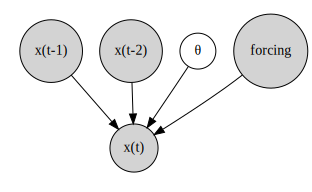

In [6]:
fno_graph(obs="fwd")

We can repeatedly invoke this to push the model forward in time

/Users/mac581/Source/hackfest-probabilistic-programming/venv/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


range(0, 50, 5) 10 5


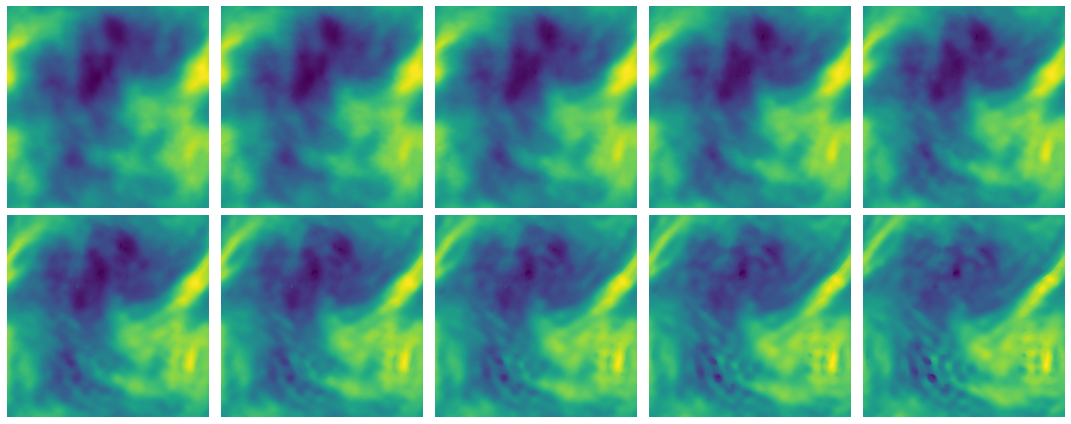

In [7]:
def predict_forward(x, latent, n_horizon=1, n_steps=2):
    x = torch.as_tensor(x).to(device)
    latent = torch.as_tensor(latent).to(device)
    process_predictor.to(device)
    for i in range(n_horizon):
        pred = process_predictor({'x': x[...,-(n_steps):], 'latent': latent})['forecast']
        x = torch.cat((x, pred), dim=-1)
    return x[...,-n_horizon:]

obs = get_obs(data, 0, 10,)

with torch.no_grad():
    pred = predict_forward(obs['x'], obs['latent'], n_horizon=50, n_steps=2)

multi_img_plot_time(pred.cpu().numpy(), n_cols=5, interval=5);
## How the teaser graphic in the README was generated:
# plt.savefig('./fno_forward_predict_sheet.jpg');

DISCLAIMER: This is _not_ the most finely tuned of this model — in fact it is one with relatively low accuracy because that makes the statistical difficulties of inference easier to see with the naked eye.

## Inversion by GD

Now we want to solve an inverse problem with this model: given some observations of $x(t), x(t-1), x(t-2)$, what is the best guess for the latent forcing field?


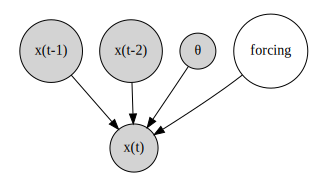

In [8]:
fno_graph(obs="inverse")

We can in fact predict and do inversion through the PDE equations directly, but this is _slow_ (hours), so we use the neural network to solve this problem directly.
Firstly, we can do this directly as pure predictive error minimisation problem. Forget the probabilistic interpretation of this problem and just minimise some loss function. 

In [9]:
class RasterLatent(nn.Module):
    def __init__(self,
            process_predictor: "nn.Module",
            dims = (256,256),
            latent_dims = None,
            interpolation = 'bilinear',
            n_batch: int=1):
        super().__init__()
        self.dims = dims
        if latent_dims is None:
            latent_dims = dims
        self.latent_dims = latent_dims
        self.interpolation = interpolation
        self.process_predictor = process_predictor
        ## Do not fit the process predictor weights
        process_predictor.train(False)
        for param in self.process_predictor.parameters():
            param.requires_grad = False
            
        self.latent = nn.Parameter(
            torch.zeros(
                (n_batch, *latent_dims),
                dtype=torch.float32
            )
        )
    
    def get_latent(self):
        if self.latent_dims==self.dims:
            return self.latent
        return F.interpolate(
            self.latent.unsqueeze(1),
            self.dims,
            mode=self.interpolation
        ).squeeze(1)  #squeeze/unsqueeze is because of weird interpolate semantics

    def weights_init(self, scale=0.005):
        self.latent.data.normal_(0.0, scale)

    def forward(self, batch):
        batch = dict(**batch)
        batch['latent'] = self.get_latent()
        return self.process_predictor(batch)

In [10]:
def fit(
        batch,
        model,
        optimizer,
        n_iter: int=20,
        check_int: int=1,
        clip_val = None,
        init_scale=0.1):
    model.train()
    model.to(device)
    model.weights_init(init_scale)
    loss_fn = nn.MSELoss()
    big_loss_fn = nn.MSELoss(reduction='none')
    scale = loss_fn(torch.zeros_like(batch['latent']), batch['latent']).item()
    for i in range(n_iter):
        # Compute prediction error
        pred = model(batch)
        loss = loss_fn(pred['forecast'], batch['y'])
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        if clip_val is not None:
            for group in optimizer.param_groups:
                torch.nn.utils.clip_grad_value_(group["params"], clip_val)

        optimizer.step()

        if i % check_int == 0 or i==n_iter-1:
            with torch.no_grad():
                loss_v = loss.item()
                # batchwise error
                big_error = big_loss_fn(model.get_latent(), batch['latent']).mean(dim=(1,2))
                big_relerr = torch.sqrt(big_error/scale)
                error = big_error.mean().item()
                relerr = sqrt(big_relerr.mean().item())
                print(
                    f"loss: {loss:.3e}, error: {error:.3e}, relerror: {relerr:.3e} [{i:>5d}/{n_iter:>5d}]")

                target =  batch['latent'][0, :, :].cpu().numpy()
                est =  model.get_latent()[0, :, :].cpu().numpy()
                err_heatmap = target - est
                multi_heatmap(
                    [target, est, err_heatmap],
                    ["Target", "Estimate", "Error"])
                plt.show();
                plt.close("all");

    return loss_v, error, relerr, scale


/Users/mac581/Source/hackfest-probabilistic-programming/venv/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/Users/mac581/Source/hackfest-probabilistic-programming/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 256, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 9.694e-02, error: 1.993e-04, relerror: 1.079e+00 [    0/   50]


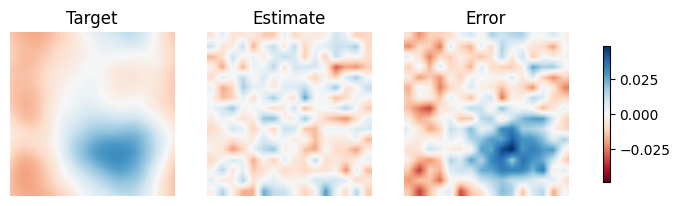

loss: 9.588e-02, error: 6.975e-04, relerror: 1.476e+00 [   10/   50]


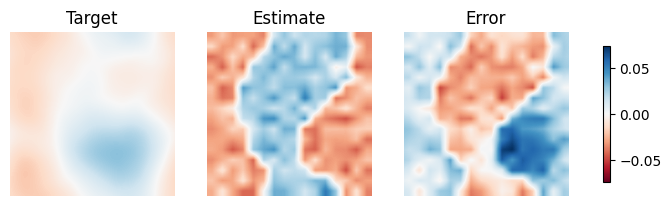

loss: 9.484e-02, error: 2.299e-03, relerror: 1.989e+00 [   20/   50]


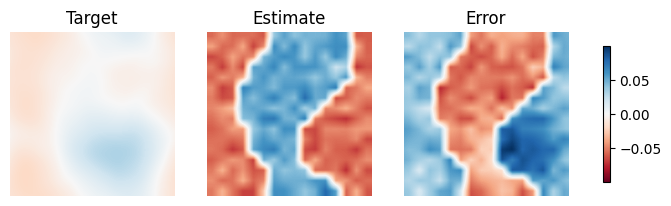

loss: 9.382e-02, error: 4.984e-03, relerror: 2.413e+00 [   30/   50]


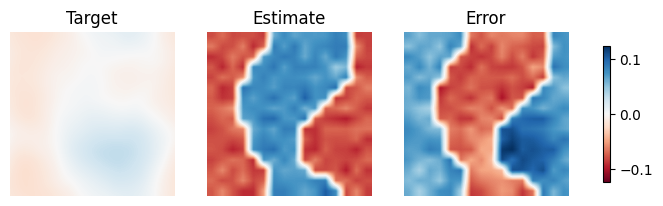

loss: 9.283e-02, error: 8.722e-03, relerror: 2.776e+00 [   40/   50]


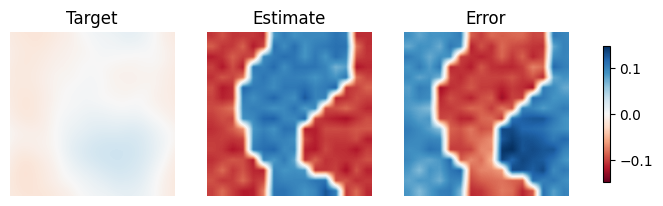

loss: 9.196e-02, error: 1.295e-02, relerror: 3.064e+00 [   49/   50]


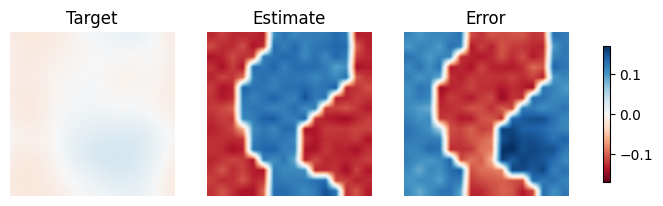

(0.0919579267501831,
 0.012953253462910652,
 3.064135523445802,
 0.00014694234414491802)

In [11]:
model = RasterLatent(
    process_predictor,
    dims=obs['x'].shape[1:3],
    latent_dims=(16,16),
    n_batch=1)
optimizer = AdamW(
    model.parameters(),
    lr=0.0025,
    weight_decay=0.0)

loss_fn = nn.MSELoss()

fit(
    dict_as_tensor(get_obs(data,t=10,n_steps=2,y=True)),
    model,
    optimizer,
    n_iter=50,
    check_int=10,
    clip_val=None,
    init_scale=0.01
)